In [1]:
# Import modules
using Distributions
using LinearAlgebra
using Plots

# Import seismic modules
using seismic.Grids
using seismic.Rays
using seismic.Inversion

# Define grid

In [2]:
## Step 1: Define grid: 50x50
nx = ny = 20
N=nx*ny
Δx = Δy = 10. / nx
# Grid array, column major
grid = makeGrid(nx,ny,Δx,Δy);

In [3]:
# Compute cell centers coordinates for convenience
xc = [ p.x for p in grid.centers ]; xcticks = sort(unique(xc))
yc = [ p.y for p in grid.centers ]; ycticks = sort(unique(yc))

## Step 2: Define source
src = Point(-400., ny*Δy/2)

## Step 3: Define a distribution of receivers
n_recs = 100
rx = rand(Uniform(minimum(grid.xticks.+2Δx),maximum(grid.xticks.-2Δx)),n_recs)
ry = rand(Uniform(minimum(grid.yticks.+2Δy),maximum(grid.yticks.-2Δy)),n_recs)
recs = Point{Float64}[]
for i in 1:n_recs
    push!(recs,Point(rx[i], ry[i]))
end

## Step 4: Construct design matrix (shape: floats x grid_boxes)
D = distanceMatrix(recs, src, grid);

In [4]:
rxx = Rxx(grid, 1., 1.)
ryy = Ryy(grid, 1.)
rnn = Rnn(D,rxx,ryy);

In [8]:
P = computeUncertaintyMatrix(D,rxx,rnn);

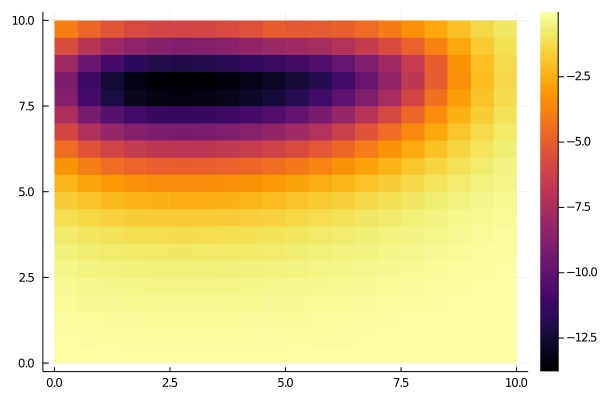

In [23]:
heatmap(grid.xticks,grid.yticks,reshape(P[200,:],grid.nx,grid.ny))

In [18]:
grid.nx * grid.ny

400